In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)


download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [2]:
# Chapter 4: Estimating Proportions
import numpy as np
from empiricaldist import Pmf
from scipy.stats import binom
import matplotlib.pyplot as plt
from utils import decorate, set_pyplot_params

set_pyplot_params()

np.set_printoptions(precision=2)

n = 2
p = 0.5
k = 1

print(binom.pmf(k, n, p))


0.5000000000000002


In [3]:
ks = np.arange(n + 1)
ps = binom.pmf(ks, n, p)
print(
    f"The result of ps={ps} is a numpy array with the probability of 0, 1, or 2 heads.\nIf these values are put into a Pmf, the result is the distribution of k for the given values of n and p."
)


The result of ps=[0.25 0.5  0.25] is a numpy array with the probability of 0, 1, or 2 heads.
If these values are put into a Pmf, the result is the distribution of k for the given values of n and p.


In [4]:
pmf_k = Pmf(ps, ks)
pmf_k


,probs
0,0.25
1,0.50
2,0.25


@label: k

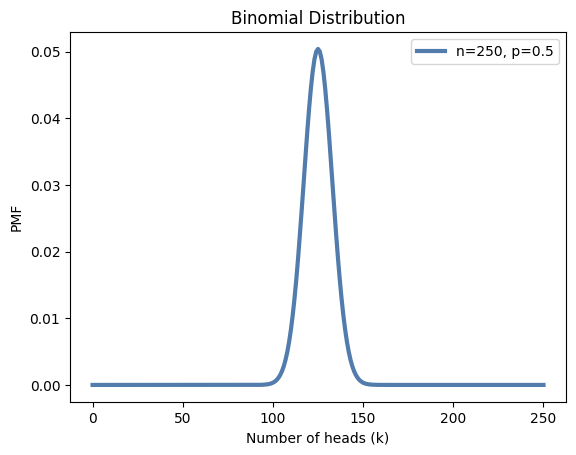

In [5]:

def make_binomial(n, p):
    ks = np.arange(n + 1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)


# heres what it looks like with n = 250 & p = 0.5
# pmf_k.plot(label='n=250, p=0.5')

# decorate(xlabel='Number of heads (k)',
#          ylabel='PMF',
#          title='Binomial distribution')

pmf_k = make_binomial(n=250, p=0.5)
fig = plt.plot(pmf_k)
plt.title("Binomial Distribution")
plt.ylabel("PMF")
plt.xlabel("Number of heads (k)")
plt.legend(["n=250, p=0.5"], loc="upper right")


In [6]:
pmf_k.max_prob()

125

In [7]:
# Even though it is the most likely quantity, the probability you get exactly 125 heads is only ~5%.
pmf_k[125]

0.05041221314730967

In [8]:
# From MacKay's example, there are 140 heads, which is even less likely than 125.
pmf_k[140]

0.008357181724918188

In [9]:
# In the article MacKay quotes, the statistician says, "if the coin were unbiased the chance of getting a result as extreme as that would be <7%."
# You can use the binomial distribution to check this math.
# The function takes a PMF and computes the total probability of quantities greater than or equal to the threshold.
def prob_ge(pmf, threshold):
    ge = (pmf.qs >= threshold)
    total = pmf[ge].sum()
    return total


# Probability of getting 140 heads or more
prob_ge(pmf_k, 140)

0.03321057562002166

In [10]:
# Pmf provides a mthod that does the same computation.
pmf_k.prob_ge(140)

0.03321057562002166

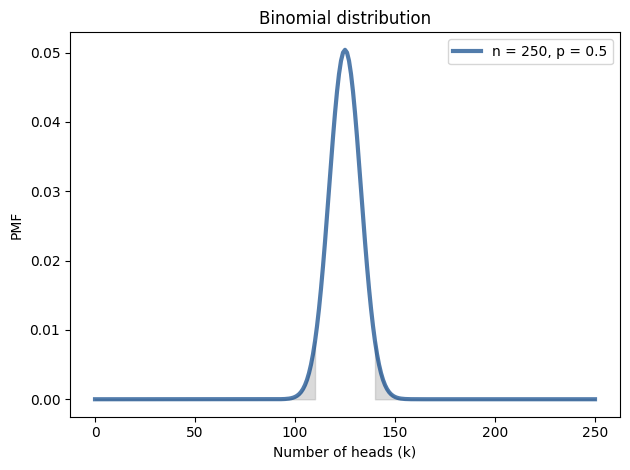

In [11]:
# Fill in the tails of the distribution
def fill_below(pmf):
    qs = pmf.index
    ps = pmf.values
    plt.fill_between(qs, ps, 0, color='C5', alpha=0.4)


qs = pmf_k.index
fill_below(pmf_k[qs >= 140])
fill_below(pmf_k[qs <= 110])
pmf_k.plot(label='n = 250, p = 0.5')
decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

# (pmf_k := make_binomial(n=250, p=0.5))
# pmf_k.plot(label = 'n = 250', p = '0.5')
# plt.title("Binomial Distribution")
# plt.ylabel("PMF")
# plt.xlabel("Number of heads (k)")
# plt.legend(["n=250, p=0.5"], loc="upper right")

In [12]:
# The total computed probabilty of the left tail:
pmf_k.prob_le(110)

0.033210575620021665

> The probability of outcomes less than or equal to 110 is also 3.3%, so the total probability of outcomes "as extreme" as 140 is 6.6%.

### Bayesian Estimation

Any given coin hsa some probability of landing heads up when spun on edge; call this probability $x$. Its reasonable to believe that $x$ depends on the physical characteristics of the coin, like its weight distribution. If the coin is perfectly balanced, $x$ is expected to be close to 50%, whereas for a lopsided coin, $x$ might be much different.

For simplicity, start from a uniform prior, which assumes that all values of x are equally likely.


In [13]:
# uniform priors created as such:
# hypos is an array of equally spaced values between 0 & 1
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)

# Use hypotheses to compute likelihoods
likeli_heads = hypos
likeli_tails = 1 - hypos

# putting the likelihoods info a dictionary to make them easier to work with later (updating, etc)
likelihood = {"H": likeli_heads, "T": likeli_tails}

# Represent the data as a string of Hs and Ts, H repeated 140 times, T repeated 110 times.

dataset = "H" * 140 + "T" * 110


# updating the prior with the dataset
def update_euro(pmf, dataset):
    """ update pmf with a given sequence of H and T. """
    for data in dataset:
        pmf *= likelihood[data]

    pmf.normalize()


> First argument is a Pmf that represents the prior. Second argument is a sequence of strings. Each time through the loop, Pmf is multiplied by the likelihood of one outcome.
> Notice that `normalize` is outside the loop, so the posterior distribution only gets normalized once, at the end. Its more efficient than normalizing it after each spin (although itll cause issues with floating-point math)


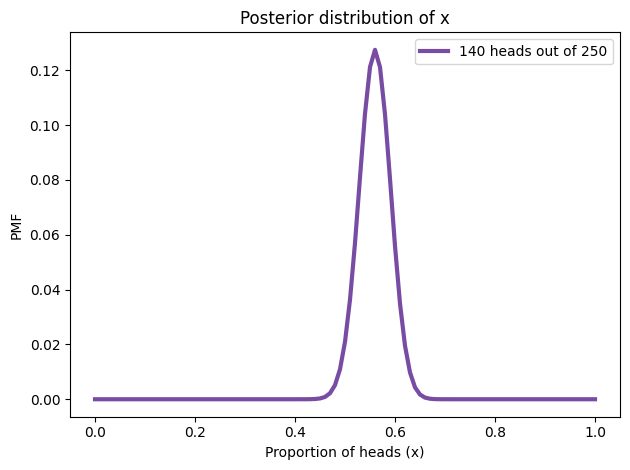

In [14]:
posterior = prior.copy()
update_euro(posterior, dataset)


def dec_euro(title):
    decorate(xlabel='Proportion of heads (x)', ylabel='PMF', title=title)


posterior.plot(label='140 heads out of 250', color='C4')
dec_euro(title='Posterior distribution of x')


> The figure shows the posterior distribution of $x$, which is the proportion of heads for the coins observed.
> It represents our beliefs about $x$ after seeing the data. Indicating that values < 0.4 or > 0.7 are unlikely; values between 0.5 and 0.6 are most likely.
> In fact, the most likely value for $x$ is 0.56, which is the proportion of heads in the datasete (140/250)


In [15]:
posterior.max_prob()

0.56

##### TODO: convert these markdown containing python snippets into quarto md code blocks such that they can be ran and the output viewed.

### Triangle Prior

> So far the uniform prior has been used:

```python
uniform = Pmf(1, hypos, name = 'uniform')
uniform.normalize()
```

> This may not be a reasonable choice based on what we know about coins. For example, if we know that the coin is almost certainly not double-headed, we can rule out all values of $x$ less than 50%. Or if the coin is lopsided, $x$ might deviate substantially from 0.5, though its unlikely to be greater than 0.8 or less than 0.2.
> Its more reasonable to choose a prior that gives higher probability to values of $x$ near 0.5 and lower probability to extreme values.
> An example: look at the triangle prior, which is a triangle-shaped distribution with its peak at 0.5 and its width at 0.5.

```python
ramp_up = np.arange(50)
ramp_do = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_do)

triangle = Pmf(a, hypos, name = 'triangle')
triangle.normalize()
```

> Here `np.arange` returns a NumPy array so that `np.append` can be used to append `ramp_do` to the end of `ramp_up`. Then use `a` and `hypos` to make a `Pmf` object.


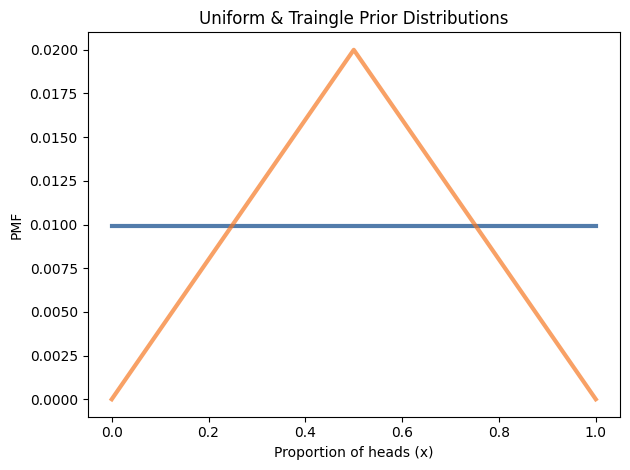

In [16]:
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

ramp_up = np.arange(50)
ramp_do = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_do)

triangle = Pmf(a, hypos, name='triangle')
triangle.normalize()

uniform.plot()
triangle.plot()
dec_euro(title='Uniform & Traingle Prior Distributions')


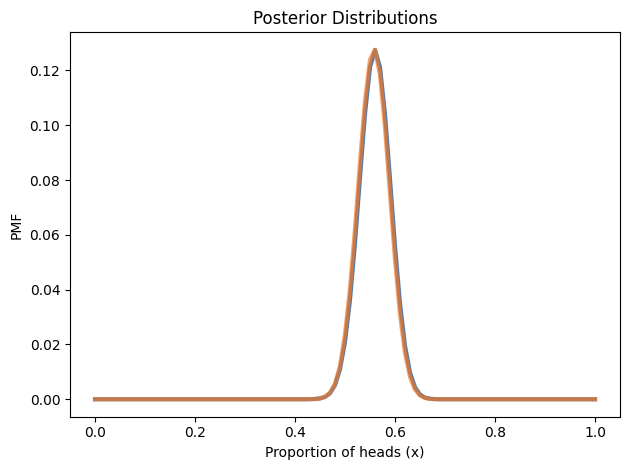

In [17]:
# Updating both priors with the same data:
update_euro(uniform, dataset)
update_euro(triangle, dataset)

# the posteriors:
uniform.plot()
triangle.plot()
dec_euro(title='Posterior Distributions')


The differences between the posterior distributions are barely visible, and so small they would hardly matter in practice.
This is good as imagine two people who disagree passionately about which prior is better, uniform or triangle. Each of them has reasons for their preference, but neither of them can persuade the other to change their mind.
Suppose they agree to update their beliefs. When they compare posterior distributions, they find that there's almost nothing left to argue about.

> This is an example of **swamping the priors**: with enough data, people who start with different priors will tend to _converge_ on the same posterior distribution.

"about the prior, but see the same data. If their priors are very different, their posteriors should be different, but if the data are strong enough, the difference should be small."


#### Binomial Likelihood Function

Computing the updates one spin at a time is inefficient. A more efficient solution is to compute the likelihood of the entire dataset at once. For each hypothetical value of $p$, we have to compute the probability of getting 140 heads out of 250 spins.

> The binomial distribution is the right tool for this job. The binomial distribution is the distribution of the number of heads we would get if we spin the coin $n$ times and $p$ is the probability of heads on any one spin.

##### If the probability of heads is $p$, the probability of $k$ heads in $n$ spins is:

$$\binom{n}{k}p^k(1-p)^{n-k}$$


In [18]:
def update_binomial(pmf, data):
    """Update pmf using binomial distribution"""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()


# Data are represented with a tuple of values for k and n, rather than a long string of outcomes; the update:
uniform2 = Pmf(1, hypos, name='uniform2')
data = 140, 250
update_binomial(uniform2, data)

# Using `np.allclose` to confirm that the result is the same as in the previous section except for a small floating point round off.
np.allclose(uniform, uniform2)

True

### Bayesian Statistics

Between the two problems earlier (Euro & 101 Bowls pg.34) The prior distributions are the same, likelihoods are the same, and with the same data, the results would be the same. There are two differences however:

- First is the choice of the prior. With 101 bowls, uniform prior is implied by the statement of the problem, which says that we choose one of the bowls at random with equal probability.
- In the Euro problem, choice of the prior is subjective; meaning, reasonable people could disagree, probably due to different information about coins or because of differing interpretations.

Because priors are subjective, the posteriors are subjective, too.
The other difference is the nature of what your estimating. In 101 bowls you chose a bowl randomly, so its uncontroversial to compute the probability of choosing each bowl. In the Euro Problem, the proportion of heads is a physical property of a given coin. Under some interpretations of probability, that’s a problem
because physical properties are not considered random.
As an example, consider the age of the universe. Currently, our best estimate is 13.80
billion years, but it might be off by 0.02 billion years in either direction.
Now suppose we would like to know the probability that the age of the universe is
actually greater than 13.81 billion years. Under some interpretations of probability,
we would not be able to answer that question. We would be required to say some‐
thing like, “The age of the universe is not a random quantity, so it has no probability
of exceeding a particular value.”
Under the Bayesian interpretation of probability, it is meaningful and useful to treat
physical quantities as if they were random and compute probabilities about them.
In the Euro Problem, the prior distribution represents what we believe about coins in
general and the posterior distribution represents what we believe about a particular
coin after seeing the data. So we can use the posterior distribution to compute proba‐
bilities about the coin and its proportion of heads.
The subjectivity of the prior and the interpretation of the posterior are key differences
between using Bayes’s theorem and doing Bayesian statistics.
Bayes’s theorem is a mathematical law of probability; no reasonable person objects to
it. But Bayesian statistics is surprisingly controversial. Historically, many people have
been bothered by its subjectivity and its use of probability for things that are not
random.
If you are interested in this history, I recommend Sharon Bertsch McGrayne’s book,
The Theory That Would Not Die.


### Chapter 5: Estimating Counts

##### Train Problem from Frederick Mosteller's _Fifty Challenging Problems in Probability with Solutions_ (1965)

"A railroad numbers its locomotives in order 1..N. One day you see a locomotive with the number 60. Estimate how many locomotives the railroad has."
Bayes breaks this problem down into two steps:

- What did we know about $N$ before we saw the data? This is the prior.
- For any given value of $N$, what is the likelihood of seeing the data (a locomotive with number 60)? This is the likelihood.

Without much basis to choose a prior, start with something simple and then consider alternatives.
Assume $N$ is equally likely to be any value from 1 to 1,000.


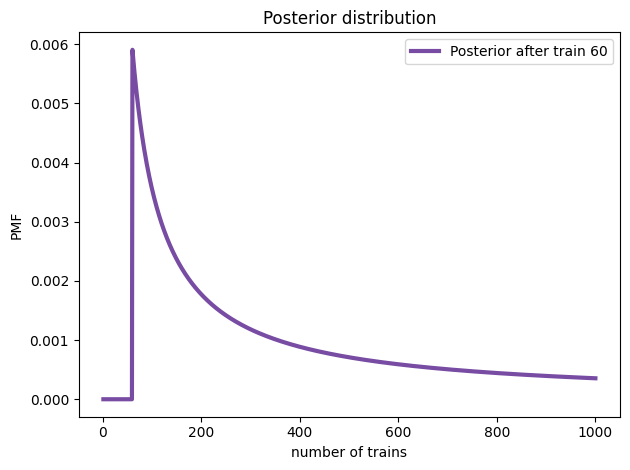

In [19]:
from matplotlib.pyplot import xlabel, ylabel

hypos = np.arange(1, 1001)
prior = Pmf(1, hypos)

# Figure out the likelihood of the data.


def update_train(pmf, data):
    hypos = pmf.qs
    likelihood = 1 / hypos
    impossible = (data > hypos)
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf.normalize()


# The problem
N = 60
posterior = prior.copy()
update_train(posterior, N)

posterior.plot(label='Posterior after train 60', color='C4')
decorate(xlabel='number of trains',
         ylabel='PMF',
         title='Posterior distribution')


In [20]:
posterior.max_prob()

60

That might not seem like a very good guess; after all, what are the chances that you
just happened to see the train with the highest number? Nevertheless, if you want to
maximize the chance of getting the answer exactly right, you should guess 60.
But maybe that’s not the right goal. An alternative is to compute the mean of the posterior distribution. Given a set of possible quantities, $q_i$, and their probabilities, $p_i$, the
mean of the distribution is:

$$ mean = \sum\_{i}{p_i q_i} $$


In [22]:
# compute the mean as such:
print(np.sum(posterior.ps * posterior.qs))

# or use the method provided by Pmf
posterior.mean()

333.41989326370776


333.41989326370776

In [ ]:
# | label: fig-cdf
# | fig-cap: "Plotting CDF"
# | fig-alt: "Posterior distribution for the Euro Problem"
"""
Chapter 7: Minimum, Maximum, & Mixture
Cumulative Distribution Functions
"""
hypos = np.linspace(0, 1, 101)
pmf = Pmf(1, hypos)
data = 140, 250


In [ ]:
def update_binomial(pmf, data):
    """Update pmf using binomial distribution"""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()


update_binomial(pmf, data)


In [ ]:
# @fig-cdf
cumulative = pmf.cumsum()
